# CIFAR 10 - adversarial networks

This notebook contains analysis of several 5 layer networks trained in caffe on the CIFAR 10 data set.

In [1]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10
import caffe

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


# If your GPU supports CUDA and Caffe was built with CUDA support,
# uncomment the following to run Caffe operations on the GPU.
caffe.set_mode_gpu()
#caffe.set_device(0) # select GPU device if multiple devices exist

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [73]:
#Load the model

model_path = '/Users/amaharaj/Documents/Courses/neural_networks/project/assignment2/' # substitute your path here
net_fn   = model_path + 'cifar10_deploy.prototxt'
param_fn = model_path + 'cifar10_disc4.caffemodel.h5'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".

net = caffe.Classifier(net_fn, param_fn,
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

In [74]:
# Load the (preprocessed) CIFAR10 data.
rawdata={}
rawdata['X_train'],rawdata['y_train'],rawdata['X_test'],rawdata['y_test'] = load_CIFAR10('cs231n/datasets/cifar-10-batches-py')


rawdata['X_train']=rawdata['X_train'].transpose(0,3,1,2) 
rawdata['X_test']=rawdata['X_test'].transpose(0,3,1,2) 

for k, v in rawdata.iteritems():
    print '%s: ' % k, v.shape

#the number of discretizations
pts = 4
rawdata['X_train_disc'] = (rawdata['X_train']//(256/pts))*(256/pts) + 0.5*(256/pts)
rawdata['X_test_disc'] = (rawdata['X_test']//(256/pts))*(256/pts) + 0.5*(256/pts)
rawdata['X_train_disc'][rawdata['X_train_disc'] > 255.0] = 255.0
rawdata['X_test_disc'][rawdata['X_test_disc'] > 255.0] = 255.0

# Subtract means from the data
meandisc_image = np.mean(rawdata['X_train_disc'], axis=0)
mean_image = np.mean(rawdata['X_train'], axis=0)
rawdata['X_train']-= mean_image
rawdata['X_test']-= mean_image
rawdata['X_train_disc']-= meandisc_image
rawdata['X_test_disc']-= meandisc_image

X_test:  (10000, 3, 32, 32)
X_train:  (50000, 3, 32, 32)
y_train:  (50000,)
y_test:  (10000,)


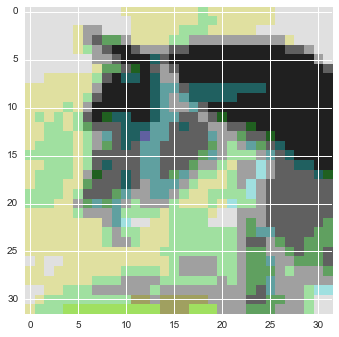

In [75]:
#Show an example of the mean subtracted data
plt.imshow((rawdata['X_train_disc'][1113] + meandisc_image).transpose(1,2,0))

In [76]:
#Now perform tests as we increase the strength of distortion

y_test = rawdata['y_test']
distortion = np.zeros(rawdata['X_test'].shape)
epsilonvec=np.zeros(40)

for i in range(40):
    epsilon = 256*0.01*i
    y_pred = np.zeros(10000)
    
    #Add the distortion
    distorted_data = rawdata['X_test_disc'] - epsilon*distortion
    
    #Re-discretize the data by adding back the mean image, discretizing then subtracting mean
    distorted_data += meandisc_image
    distorted_data = (distorted_data//(256/pts))*(256/pts) + 0.5*(256/pts)
    distorted_data -= meandisc_image
    
    for j in range(100):
        low = 100*j
        up = 100*(j+1)
        net.blobs['data'].data[...] = distorted_data[low:up]
        output = net.forward()
        backward = net.backward(**{net.outputs[0]: net.blobs['loss'].data})
        distortion[low:up] = np.sign(backward['data'])
        y_pred[low:up]=np.argmax(output['loss'],axis =1)
    
    epsilonvec[i] = epsilon
    accvec[i,0] = (y_pred == y_test).mean()

    print "distortion: %f, accuracy: %f"% (epsilon,(y_pred == y_test).mean())
    
np.save("accuracy_evolution", accvec)

distortion: 0.000000, accuracy: 0.751700
distortion: 2.560000, accuracy: 0.751700
distortion: 5.120000, accuracy: 0.751700
distortion: 7.680000, accuracy: 0.751700
distortion: 10.240000, accuracy: 0.751700
distortion: 12.800000, accuracy: 0.751700
distortion: 15.360000, accuracy: 0.751700
distortion: 17.920000, accuracy: 0.751700
distortion: 20.480000, accuracy: 0.751700
distortion: 23.040000, accuracy: 0.751700
distortion: 25.600000, accuracy: 0.751700
distortion: 28.160000, accuracy: 0.751700
distortion: 30.720000, accuracy: 0.751700
distortion: 33.280000, accuracy: 0.069100
distortion: 35.840000, accuracy: 0.149900
distortion: 38.400000, accuracy: 0.123600
distortion: 40.960000, accuracy: 0.166600
distortion: 43.520000, accuracy: 0.139900
distortion: 46.080000, accuracy: 0.150000
distortion: 48.640000, accuracy: 0.137400
distortion: 51.200000, accuracy: 0.153000
distortion: 53.760000, accuracy: 0.138200
distortion: 56.320000, accuracy: 0.144800
distortion: 58.880000, accuracy: 0.147

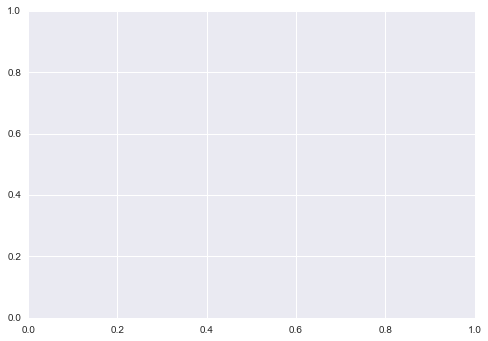

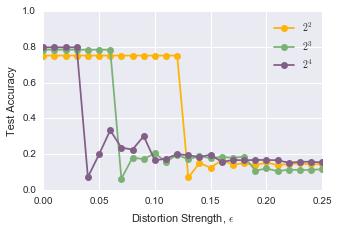

In [18]:
#Plot the results of these tests

import numpy as np
import seaborn as sns
accvec = np.load("numpy_data/accuracy_evolution.npy")
epsilonvec = np.array([256*0.01*i for i in range(40)])
width = 2
height = 1.25
fig, ax1 = sns.plt.subplots()
plt.figure(num=None, figsize=(5, 3.2), dpi=80, facecolor='w', edgecolor='k')
sns.plt.plot(epsilonvec/256,accvec[:,0],'o-',epsilonvec/256, accvec[:,1],'o-',epsilonvec/256, accvec[:,2],'o-')
sns.plt.xlabel("Distortion Strength, "+ r"$\epsilon$")
sns.plt.ylabel("Test Accuracy")
sns.plt.legend([r"$2^{2}$", r"$2^3$", r"$2^4$"])
sns.plt.ylim((0,1))
sns.plt.xlim((0,0.25))
#plt.legend(["Raw", "GrayScale", "Discretized"])
sns.plt.savefig("accuracies_evolution1.eps",figsize=(4,3))
sns.plt.show()

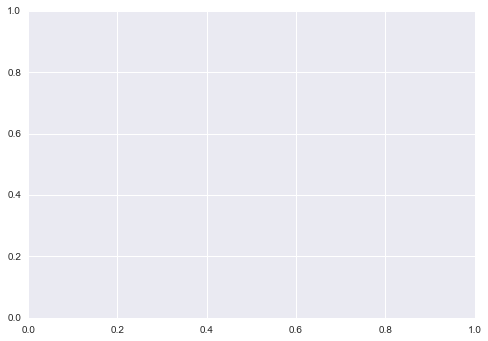

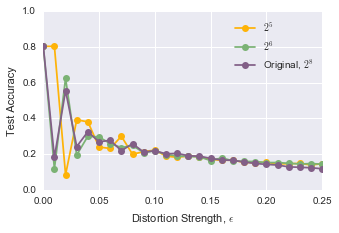

In [19]:
#More results plotting

import seaborn as sns
#rawdata['X_train'],rawdata['y_train'],rawdata['X_test'],rawdata['y_test'] = load_CIFAR10('cs231n/datasets/cifar-10-batches-py')
flatui = [ "#e74c3c", "#34495e", "#2ecc71"]
colors = ["amber", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

width = 2
height = 1.25

fig, ax = sns.plt.subplots()
plt.figure(num=None, figsize=(5, 3.2), dpi=80, facecolor='w', edgecolor='k')
sns.plt.plot(epsilonvec/256,accvec[:,3],'o-',epsilonvec/256, accvec[:,4],'o-',epsilonvec/256, accvec[:,5],'o-')
sns.plt.xlabel("Distortion Strength, "+ r"$\epsilon$")
sns.plt.ylabel("Test Accuracy")
sns.plt.legend([r"$2^{5}$", r"$2^6$", "Original, " + r"$2^8$"])
sns.plt.ylim((0,1))
sns.plt.xlim((0,0.25))
#plt.legend(["Raw", "GrayScale", "Discretized"])
sns.plt.savefig("accuracies_evolution2.eps",figsize=(4,3))
sns.plt.show()

# Accuracies of different models tested against eachother

In [6]:
#Re-load the data
rawdata={}

rawdata['X_train']=rawdata['X_train'].transpose(0,3,1,2) 
rawdata['X_test']=rawdata['X_test'].transpose(0,3,1,2) 

for k, v in rawdata.iteritems():
    print '%s: ' % k, v.shape

X_test:  (10000, 3, 32, 32)
X_train:  (50000, 3, 32, 32)
y_train:  (50000,)
y_test:  (10000,)


In [19]:
#Load the model

model_path = '/Users/amaharaj/Documents/Courses/neural_networks/project/assignment2/' # substitute your path here
net_fn   = model_path + 'cifar10_deploy.prototxt'
param_fn = model_path + 'cifar10_disc128.caffemodel.h5'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".

net = caffe.Classifier(net_fn, param_fn,
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB




#the number of discretizations
pts = 4
tdata = {}
tdata['X_train_disc'] = (rawdata['X_train']//(256/pts))*(256/pts) + 0.5*(256/pts)
tdata['X_test_disc'] = (rawdata['X_test']//(256/pts))*(256/pts) + 0.5*(256/pts)
tdata['X_train_disc'][tdata['X_train_disc'] > 255.0] = 255.0
tdata['X_test_disc'][tdata['X_test_disc'] > 255.0] = 255.0

# Subtract means from the data
meandisc_image = np.mean(tdata['X_train_disc'], axis=0)
mean_image = np.mean(rawdata['X_train'], axis=0)
tdata['X_train_disc']-= meandisc_image
tdata['X_test_disc']-= meandisc_image

y_pred = np.zeros(10000)
y_test = rawdata['y_test']

for j in range(100):
    low = 100*j
    up = 100*(j+1)
    net.blobs['data'].data[...] = tdata['X_test_disc'][low:up]
    out = net.forward()
    y_pred[low:up]=np.argmax(out['loss'],axis =1)


print "accuracy= ",(y_pred == y_test).mean()

accuracy=  0.6011


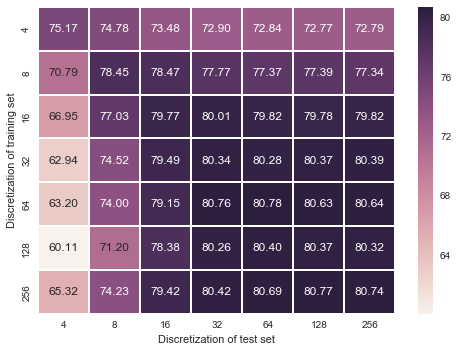

In [83]:
vals = ["4","8","16","32","64","128","256"]


heatmap_arr = np.array((7,7))
heatmap_arr= np.array([[0.7517,0.7478,0.7348,0.729,0.7284,0.7277,0.7279]
,[0.7079,0.7845,0.7847,0.7777,0.7737,0.7739,0.7734]
,[0.6695,0.7703,0.7977,0.8001,0.7982,0.7978,0.7982]
,[0.6294,0.7452,0.7949,0.8034,0.8028,0.8037,0.8039]
,[0.6320,0.7400,0.7915,0.8076,0.8078,0.8063,0.8064]
,[0.6011,0.7120,0.7838,0.8026,0.8040,0.8037,0.8032]
,[0.6532,0.7423,0.7942,0.8042,0.8069,0.8077,0.8074]])

import seaborn as sns
sns.heatmap(heatmap_arr*100,annot=True, fmt=".2f", linewidths=.9, xticklabels=vals,yticklabels=vals)
sns.plt.xlabel("Discretization of test set")
sns.plt.ylabel("Discretization of training set")

sns.plt.savefig("heatmap_accuracies.eps")
np.save("accuracy_heatmap",heatmap_arr)